### References
- https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
- https://github.com/soumith/ganhacks

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2 as T
import torchvision.utils as vutils
import random

In [12]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 64
NZ = 256        # Размер векторра шума z
NGF = 32        # Размер модификатора каналов в генераторе
NDF = 32        # Размер модификатора каналов в дискриминаторе
NC = 3          # Количество каналов в изображении
BETA_1 = 0.5    # B1 коэффициент оптимизатора
CLASS_N = 11    # Количество классов в датасете

In [13]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input: NZ
            nn.ConvTranspose2d(NZ, NGF * 12, 4, 1, 0, bias=False),
            nn.BatchNorm2d(NGF * 12),
            nn.ReLU(True),
            # ngf*12 x 4 x 4 
            nn.ConvTranspose2d(NGF * 12, NGF * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF * 8),
            nn.ReLU(True),
            # ngf*8 x 8 x 8 
            nn.ConvTranspose2d(NGF * 8, NGF * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF * 4),
            nn.ReLU(True),
            # ngf*4 x 16 x 16
            nn.ConvTranspose2d(NGF * 4, NGF * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF * 2),
            nn.ReLU(True),
            # ngf*2 x 32 x 32
            nn.ConvTranspose2d(NGF * 2, NGF , 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF),
            nn.ReLU(True),
            # ngf x 64 x 64
            nn.ConvTranspose2d(NGF, NC, 4, 2, 1, bias=False),
            nn.Tanh(),
            # nc x 128 x 128
        )

    def forward(self, x, rnd=0.005):
        x = self.main(x)
        noise = (rnd**0.5)*torch.randn(x.shape, device=DEVICE).detach()
        return x + noise

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input: nc x 128 x 128
            nn.Conv2d(NC, NDF, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf x 64 x 64
            nn.Conv2d(NDF, NDF * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf*2 x 32 x 32
            nn.Conv2d(NDF * 2, NDF * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf*4 x 16 x 16
            nn.Conv2d(NDF * 4, NDF * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf*8 x 8 x 8
            nn.Conv2d(NDF * 8, NDF * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf*8 x 4 x 4
        )

        self.image_classification = nn.Sequential(
            nn.Conv2d(NDF * 8, CLASS_N, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self.fake_classification = nn.Sequential(
            nn.Conv2d(NDF * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        fake = self.fake_classification(x)
        label = self.image_classification(x)
        return fake, label

In [15]:
def train(models, data_loader: DataLoader, optimizers: tuple, loss_fn, class_loss_fn, rnd=0.005):
    D, G = models
    G.train()
    D.train()

    d_optim, g_optim = optimizers
    train_d_loss, train_g_loss = 0, 0

    for real_img, class_label in data_loader:
        real_img, class_label = real_img.to(DEVICE), class_label.to(DEVICE)
        batch_size = real_img.size(0)

        fake_img = G(torch.randn(batch_size, NZ, 1, 1, device=DEVICE), rnd)

        # добавляем шум в входные данные
        real_img = real_img + (rnd**0.5)*torch.randn(real_img.shape, device=DEVICE).detach()
       
        # тренируем дискриминатор
        d_optim.zero_grad()
        # реальные изображения
        true_outs, label = D(real_img)
        d_real_loss = loss_fn(true_outs, torch.ones_like(true_outs, device=DEVICE).uniform_(0.9, 0.9))
        d_real_loss = d_real_loss + class_loss_fn(label.squeeze(2, 3), class_label)
        d_real_loss.backward()

        # фейковые изображения
        fake_outs, _ = D(fake_img.detach())
        d_fake_img_loss = loss_fn(fake_outs, torch.zeros_like(fake_outs, device=DEVICE))
        d_fake_img_loss.backward()  
        d_optim.step()
        
        # тренируем генератор
        g_optim.zero_grad()
        fake_outs_, _ = D(fake_img)
        g_loss = loss_fn(fake_outs_, torch.ones_like(fake_outs_, device=DEVICE).uniform_(0.9, 0.9))
        g_loss.backward()
        g_optim.step()

        train_d_loss += (d_real_loss + d_fake_img_loss).item()
        train_g_loss += g_loss.item()

    train_g_loss /= len(data_loader)
    train_d_loss /= len(data_loader)

    return train_d_loss, train_g_loss

In [16]:
image_dataset = ImageFolder(
    root='planets\\',
    transform=T.Compose([
        T.Resize(128),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]))
data_loader = torch.utils.data.DataLoader(image_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
G = Generator()
D = Discriminator()

G.apply(weights_init)
D.apply(weights_init)

G.to(DEVICE)
D.to(DEVICE)

g_optim = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(BETA_1, 0.999))
d_optim = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(BETA_1, 0.999))
loss_fn = nn.BCELoss()
class_loss_fn = nn.CrossEntropyLoss()

In [18]:
fix_noise = torch.randn(16, NZ, 1, 1, device=DEVICE)


def plot_examples(title=None):
    G.eval()
    D.eval()

    plt.figure(figsize=(10, 4))
    images = G(fix_noise)

    plt.imshow(np.transpose(vutils.make_grid(images.cpu(), padding=5, normalize=True), (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()

In [19]:
def change_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr

epoch:1, d loss:2.4942470840785815, g loss:4.525849197221839
epoch:2, d loss:2.1192476749420166, g loss:6.383847982987113
epoch:3, d loss:2.0827052800551704, g loss:6.7232424901879355
epoch:4, d loss:2.1472637238709824, g loss:8.663575462673021
epoch:5, d loss:2.02015859666078, g loss:6.552708998970363
epoch:6, d loss:1.9525119895520417, g loss:6.032607182212498
epoch:7, d loss:1.966008766837742, g loss:6.072142766869587
epoch:8, d loss:2.0540542706199316, g loss:9.268814397894818
epoch:9, d loss:1.9882624926774397, g loss:7.083743551503057
epoch:10, d loss:2.0128924742988916, g loss:8.48380708694458
epoch:11, d loss:2.3971343610597695, g loss:8.476442819056304
epoch:12, d loss:2.04562492992567, g loss:7.005643191544906
epoch:13, d loss:2.026543871216152, g loss:5.8770919468091884
epoch:14, d loss:2.117063195809074, g loss:5.376641382341799
epoch:15, d loss:2.044126111528148, g loss:4.904623757237974
epoch:16, d loss:2.190685235935709, g loss:4.451433277648428
epoch:17, d loss:2.177414

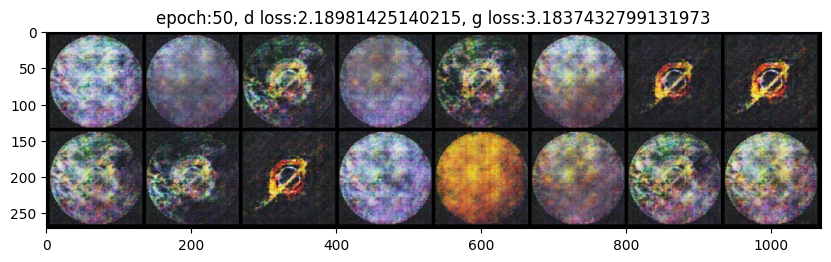

epoch:51, d loss:2.244343726531319, g loss:2.8398013685060586
epoch:52, d loss:2.170996043993079, g loss:3.1252353191375732
epoch:53, d loss:2.043512359909389, g loss:3.21939276094022
epoch:54, d loss:2.241310601649077, g loss:3.2471431934315227
epoch:55, d loss:2.2370712290639463, g loss:3.5899919789770376
epoch:56, d loss:2.2094470884488975, g loss:3.001993739086649
epoch:57, d loss:2.1668138400368067, g loss:2.847543742345727
epoch:58, d loss:2.284829777220021, g loss:2.990020145540652
epoch:59, d loss:2.171838190244592, g loss:3.438312105510546
epoch:60, d loss:2.2273040232451065, g loss:2.700830516607865
epoch:61, d loss:2.193410002666971, g loss:3.099953936493915
epoch:62, d loss:2.151249191035395, g loss:3.14964845387832
epoch:63, d loss:2.2668988756511523, g loss:3.6906429477359937
epoch:64, d loss:2.1294895825178726, g loss:3.418804002844769
epoch:65, d loss:2.0466105626977007, g loss:3.2736369112263555
epoch:66, d loss:2.1659587829009346, g loss:3.6751593403194263
epoch:67, d

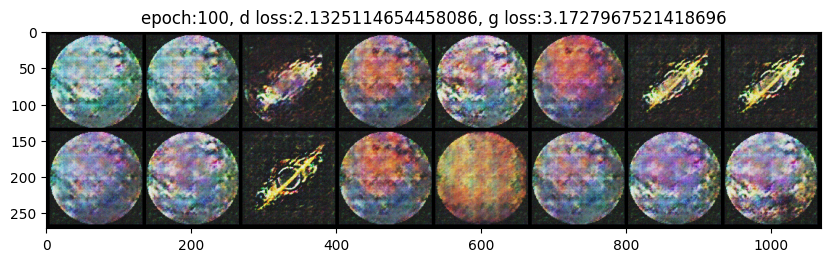

epoch:101, d loss:2.1324597856272822, g loss:2.6515619702961133
epoch:102, d loss:2.180151669875435, g loss:2.8123625102250474
epoch:103, d loss:2.1039061805476313, g loss:2.8600052646968677
epoch:104, d loss:1.990364214648371, g loss:3.2808162025783374
epoch:105, d loss:2.0476456932399585, g loss:2.969257608703945
epoch:106, d loss:2.078550986621691, g loss:2.9266727955445
epoch:107, d loss:2.0384123636328657, g loss:3.1661843424258023
epoch:108, d loss:2.0425970347031304, g loss:3.1151578115380327
epoch:109, d loss:1.9572720113007918, g loss:3.3917213211888853
epoch:110, d loss:2.151511980139691, g loss:3.2140217190203457
epoch:111, d loss:2.055003819258317, g loss:2.983514827230702
epoch:112, d loss:2.093256204024605, g loss:3.199224347653596
epoch:113, d loss:2.048303194667982, g loss:3.086302104203597
epoch:114, d loss:1.9876316837642505, g loss:3.415893502857374
epoch:115, d loss:1.9719313383102417, g loss:3.485856823299242
epoch:116, d loss:1.9923806553301604, g loss:3.461557740

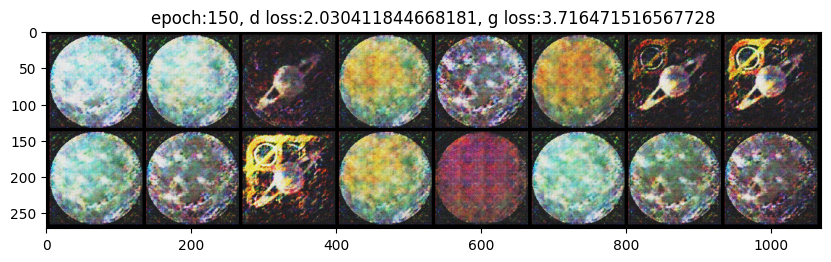

epoch:151, d loss:1.9546143490335215, g loss:3.4251335496487827
epoch:152, d loss:1.982061997703884, g loss:3.353091467981753
epoch:153, d loss:2.0130880138148433, g loss:3.1264906603357066
epoch:154, d loss:2.0724340677261353, g loss:3.0683232494022534
epoch:155, d loss:1.970746610475623, g loss:3.1544806957244873
epoch:156, d loss:1.9223621254381926, g loss:3.673445400984391
epoch:157, d loss:1.9354584372561912, g loss:3.9771214775417163
epoch:158, d loss:2.106158505315366, g loss:3.7764405063960864
epoch:159, d loss:1.9845489004383916, g loss:3.2897933255071226
epoch:160, d loss:1.930071877396625, g loss:3.6302732384723164
epoch:161, d loss:2.040196947429491, g loss:3.014901560285817
epoch:162, d loss:1.9786174452823142, g loss:3.152861315271129
epoch:163, d loss:1.9388241871543552, g loss:3.3922390212183413
epoch:164, d loss:2.0423288293506787, g loss:3.00233795331872
epoch:165, d loss:2.0158534568289053, g loss:3.3264111643252163
epoch:166, d loss:1.9587463606958804, g loss:3.3966

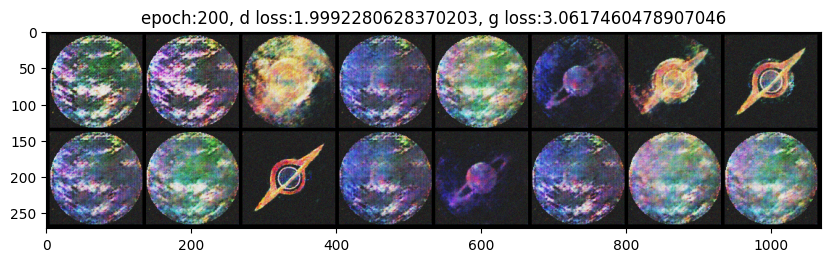

epoch:201, d loss:2.062266417171644, g loss:2.931948931320854
epoch:202, d loss:2.001340653585351, g loss:2.991093448970629
epoch:203, d loss:1.9958349829134734, g loss:2.847992855569591
epoch:204, d loss:2.0216946912848432, g loss:3.010352424953295
epoch:205, d loss:1.9461457314698591, g loss:2.9919832167418106
epoch:206, d loss:2.0409937734189243, g loss:3.131911972294683
epoch:207, d loss:1.966467085091964, g loss:3.0563525738923447
epoch:208, d loss:1.9396551380986753, g loss:3.111017320467078
epoch:209, d loss:2.0175463064857153, g loss:3.099266933358234
epoch:210, d loss:2.0190033238867056, g loss:2.930796856465547
epoch:211, d loss:2.0680336278417837, g loss:3.0043353101481562
epoch:212, d loss:2.023996316868326, g loss:2.759599727133046
epoch:213, d loss:2.058955192565918, g loss:2.669440217640089
epoch:214, d loss:1.9540289018465125, g loss:2.9082843220752217
epoch:215, d loss:1.954786145168802, g loss:2.879429920859959
epoch:216, d loss:2.0205229417137476, g loss:2.9127100757

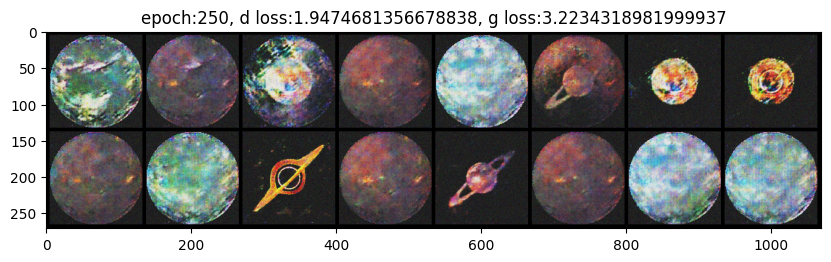

epoch:251, d loss:2.0422212300093276, g loss:3.088755524676779
epoch:252, d loss:2.026981447053992, g loss:3.034671234047931
epoch:253, d loss:2.0302298535471377, g loss:2.9438602924346924
epoch:254, d loss:1.9731395192768262, g loss:2.981898712075275
epoch:255, d loss:1.9577198443205461, g loss:3.196964626726897
epoch:256, d loss:2.03975728802059, g loss:3.28471649211386
epoch:257, d loss:2.010269989138064, g loss:2.955853099408357
epoch:258, d loss:1.965055709299834, g loss:2.9405536547951074
epoch:259, d loss:2.0724696283755093, g loss:3.270875526511151
epoch:260, d loss:1.9655132604681926, g loss:2.9896524159804634
epoch:261, d loss:1.9889185273129006, g loss:3.350019610446432
epoch:262, d loss:1.9926377845847087, g loss:3.0627482870350713
epoch:263, d loss:1.9367721858231917, g loss:3.289325009221616
epoch:264, d loss:1.952169630838477, g loss:3.362127055292544
epoch:265, d loss:1.9504447657129038, g loss:3.1954269720160444
epoch:266, d loss:1.9880752667136814, g loss:3.3244573448

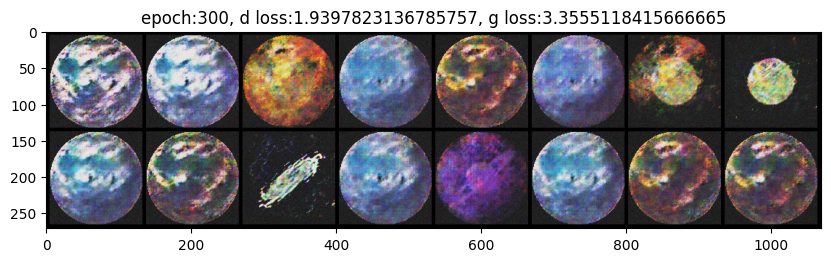

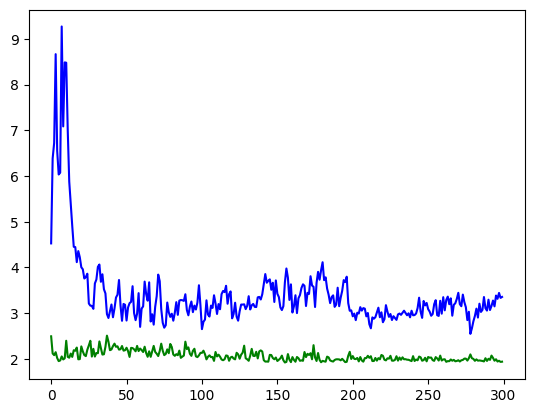

In [20]:
all_d_loss, all_g_loss = [], []
rnd = random.uniform(0, 0.2)
for e in range(1, 301):
    if e == 100:
        change_lr(g_optim, 1e-4)
        change_lr(d_optim, 1e-4)
        rnd = random.uniform(0, 0.1)
    if e == 200:
        change_lr(g_optim, 2e-5)
        change_lr(d_optim, 2e-5)
        rnd = random.uniform(0, 0.05)

    d_loss, g_loss = train((D, G), data_loader, (d_optim, g_optim), loss_fn, class_loss_fn, rnd)
    all_d_loss.append(d_loss)
    all_g_loss.append(g_loss)
    print(f'epoch:{e}, d loss:{d_loss}, g loss:{g_loss}')
    if e % 50 == 0:
        plot_examples(f'epoch:{e}, d loss:{d_loss}, g loss:{g_loss}')

plt.plot(all_d_loss, color='green')
plt.plot(all_g_loss, color='blue')
plt.show()

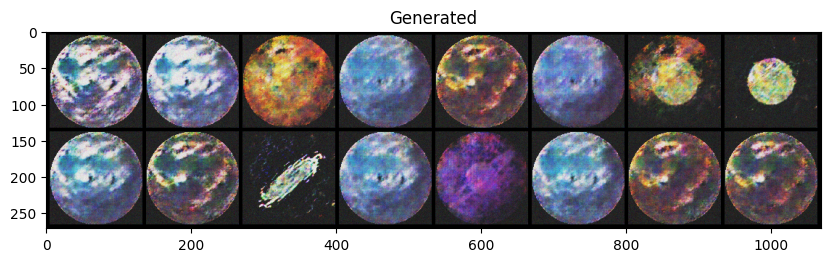

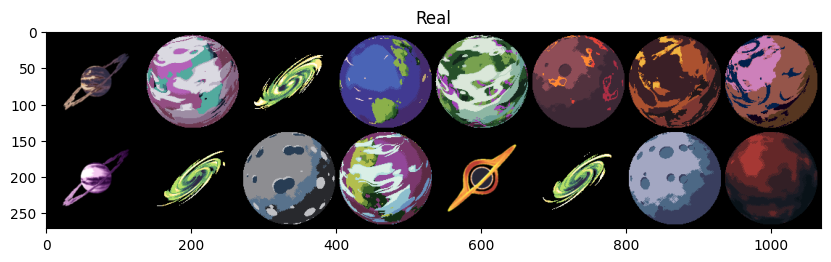

In [22]:
plot_examples('Generated')
plt.figure(figsize=(10, 4))
plt.imshow(np.transpose(vutils.make_grid(next(iter(data_loader))[0][:16], padding=5, normalize=True), (1, 2, 0)))
plt.title('Real')
plt.show()